---
# Spatial Pooler
- SDR (Sparse Destribution Representation, 희소 분포 표상) 생성
- 입력에 대해 pooler 를 이루고 있는 column 들의 일부 (=~2% 내외) 만 활성화 한다
- 모든 column 이 비슷한 빈도로 active 되어야함
- 모든 column 의 synapse 들이 비슷한 빈도로 active 되어야함


- [x] 1-d array column structure
- [ ] potential synapse - make tunable, randomly
- [ ] hard testing
- [ ] visualizing method

---

> col : 128, in_size : 32, threshold : 3, perm : 0.8, w : 10, val : 0-30 일 때 안정적인듯. 비슷한 입력에 대해서 유사한 SDR 공간을 공유하고 sparsity 가 일정했고 overlap duty 동 적당했다. 이유는?
---

In [47]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import math
import nbimporter
import Encoder
import random
import time

In [88]:
class SpatialPooler:
    def __init__(self, input_size, columns=100, conPerm=.5, minOver=5, potential_rate=.8):
        self.input_size = input_size                               # input vector 크기
        self.input_data = np.empty([self.input_size])
        self.columnCount = columns                                 # column 의 가로 크기
        self.connectedPerm = conPerm                               # synapse 활성화(1) 될 permanence 임계치
        self.min_overlap = minOver                                 # 발화 하기 위한 컬럼 당 최소한의 overlap count
        self.minGlobalActivity = 0                                 # 승리하기 위해 필요한 score (global inhibition)
        self.desiredGlobalActivity = int(0.05 * self.columnCount)  # 한 번에 승리할 column 수 (global inhibition)
        self.minDutyCycle = 0                                      # column 당 최소 발화 duty
        self.highDutyCycle = 0
        self.permanence_inc = .01                                  # 학습시 permanence 증가량
        self.permanence_dec = .01                                  # 학습시 permanence 감소량
        self.history_capacity = 100
        self.step = 0                                              # 데이터 처리한 수
        self.potential_rate = potential_rate                       # 입력 데이터에 대한potential synapses 의 비율
        self.potential_count = int(self.input_size*self.potential_rate)
        
        self.potential_synapses = np.random.random([self.input_size, self.columnCount])   # potential synapses(proxiaml dendrite) - permanence ndarry. 초기화 필요      
        self.connected_synapses = np.zeros([self.input_size, self.columnCount])           # 연결된 synapses
        self.boosts = np.ones([self.columnCount])                                             # 보정에 필요한 boost 
        self.overlapped = np.zeros([self.columnCount])                                        # input 과 연결된 synapse 들과의 최초 계산
        self.activeColumns = np.zeros([self.columnCount])
        self.activeHistory = []                                            # active duty 를 계산하기 위한 active 기록
        self.overlapHistory = []                                           # overlap duty 를 계산하기 위한 overlap 기록
        self.activeDutyInfo = np.zeros([self.columnCount])                 # active duty 정보
        self.overlapDutyInfo = np.zeros([self.columnCount])                # overlap duty 정보
        
        # potential synapses 구성
        
        for col in range(self.columnCount):
            never_connect = self.input_size - self.potential_count

            while(never_connect > 0):
                idx = random.randint(0, self.input_size - 1)

                if(self.potential_synapses[idx, col] != -1):
                    self.potential_synapses[idx, col] = -1
                    never_connect -= 1
        
        ## duty 계산을 위한 history 생성 ##
        for c in range(self.columnCount):
            self.activeHistory.append(collections.deque())
            self.overlapHistory.append(collections.deque())
            
                
    ''' SDR 생성 '''
    def compute_SDR(self, input_data):
        
        self.input_data = input_data
        
        ## 1. overlaping ##
        self.connected_synapses = self.potential_synapses > self.connectedPerm
        self.overlapped = self.input_data @ self.connected_synapses
        
        for c in range(self.columnCount):
            if(self.overlapped[c] > self.min_overlap):
                self.overlapped[c] *= self.boosts[c]

                if(len(self.overlapHistory[c]) >= self.history_capacity):
                    self.overlapHistory[c].popleft()

                self.overlapHistory[c].append(True)

            else:
                self.overlapped[c] = 0

                if(len(self.overlapHistory[c]) >= self.history_capacity):
                    self.overlapHistory[c].popleft()

                self.overlapHistory[c].append(False)
                    
                    
        ## 2. inhibition (global) ##
        self.minGlobalActivity = self.kthScore(self.desiredGlobalActivity)
        self.activeColumns = self.overlapped > self.minGlobalActivity
        
        for c in range(self.columnCount):                
            if(len(self.activeHistory[c]) >= self.history_capacity):
                self.activeHistory[c].popleft()

            self.activeHistory[c].append(self.activeColumns[c])
                    
                
        ## 3. learning ## 
        for c in range(self.columnCount):
                
            if(self.activeColumns[c] == 1):
                for s in range(self.input_size):
                    
                    if(self.potential_synapses[s, c] != -1):
                        if(self.input_data[s] == 1):
                            self.potential_synapses[s, c] += self.permanence_inc
                            self.potential_synapses[s, c] = min(self.potential_synapses[s, c], 1.0)
                        else:
                            self.potential_synapses[s, c] -= self.permanence_dec
                            self.potential_synapses[s, c] = max(0.0, self.potential_synapses[s, c])
                                            
                    
        ## 3.2. 보정 작업 ##
        self.update_activeDuty()
        self.update_overlapDuty()
        self.step += 1
        
        for c in range(self.columnCount):
            ## 자주 승리하지 못하는 column 에 대하여 잘 발화할 수 있도록 boost 시켜줌
            maxDuty, highDuty = self.maxhighDutyCycle()
            self.minDutyCycle = .1 * maxDuty
            self.highDutyCycle = highDuty
            #print("min :", self.minDutyCycle)
            self.boostFunction(c, .01)
            #print(self.boosts)

            ## input 과 잘 겹치지 않는 synapse 에 대해서 permanence 증가시켜줌
            if(self.overlapDutyInfo[c] < self.minDutyCycle):
                self.increase_Permanence(c)
                #print("min", self.minDutyCycle)

                
# ------------------------------------------------------------------------------------------ #
# ------------------------------------------------------------------------------------------ #


    def getActiveColumns(self):
        return self.activeColumns
                        
                        
    ''' global 하게 승리할 컬럼의 기준 '''
    def kthScore(self, desired_kth):
        
        rank = self.overlapped.ravel().copy()
        rank.sort()        
        score = rank[-desired_kth]
        
        return score
    
    
    ''' global 하게 가장 자주 승리한 컬럼의 duty '''
    def maxhighDutyCycle(self):
        
        rank = self.activeDutyInfo.ravel().copy()
        rank.sort()
        maxDuty = rank[-1]
        highDuty = rank[-int(self.input_size/5)]
        
        return maxDuty, highDuty
    

    
    ''' 해당 column 이 발화하도록 격려 '''
    def boostFunction(self, c, boost):
        if(self.activeDutyInfo[c] <= self.minDutyCycle):
            self.boosts[c] += boost
        elif(self.activeDutyInfo[c] > self.highDutyCycle):
            self.boosts[c] -= boost
            
            
    ''' 해당 column 의 모든 petential synapse 의 permanence 를 증가시켜 잘 겹치도록 격려 '''
    def increase_Permanence(self, c):
        for s in range(self.input_size):
            if(self.potential_synapses[s, c] != -1):
                self.potential_synapses[s, c] += self.permanence_inc
        
        
    ''' activeDuty update '''
    def update_activeDuty(self):
        for c in range(self.columnCount):
            self.activeDutyInfo[c] = np.mean(self.activeHistory[c])

                
    ''' overlapDuty update '''
    def update_overlapDuty(self):
        for c in range(self.columnCount):
            self.overlapDutyInfo[c] = np.mean(self.overlapHistory[c])
    
    def visualize_SDR(self):
        fig = plt.figure(figsize=(20,1))
        plt.imshow(self.activeColumns.reshape(1, self.columnCount))
        #plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        #cax = plt.axes([0.85, 0.1, 0.075, 0.8])
        #plt.colorbar(cax=cax)
        #plt.show()
        
        sparsity = (np.count_nonzero(self.activeColumns==True)/(self.columnCount))
        return sparsity
    
    def test(self):
        idx = []
        for i in range(len(self.activeColumns)):
            if(self.activeColumns[i] == 1):
                idx.append(i)
        return idx

In [111]:
sp = SpatialPooler(32, 128, .8, 3, potential_rate=.7)
se = Encoder.ScalarEncoder(out_size=32, max_val=30, w=10)

In [120]:
step = 500
encoded_data = 0

start = time.time()
for i in range(step):
    rand = random.randint(0, se.max_val)
    encoded_data = se.encode(rand)
    sp.compute_SDR(encoded_data)
    
print(time.time() - start)

5.380678653717041


[14, 18, 43, 60, 91]
[10, 11, 18, 43, 91]
[12, 43, 83, 110, 117]
[19, 43, 83, 110, 117]
[19, 43, 83, 110, 117]
[43, 56, 78, 110, 117]
[16, 43, 71, 110, 117]
[10, 11, 61, 62, 120]
[10, 11, 61, 62, 120]
[11, 51, 93, 110, 126]
[10, 11, 38, 51, 126]
[10, 11, 18, 38, 71]
[10, 11, 18, 38, 71]
[10, 11, 38, 94, 101]
[10, 18, 47, 71, 122]
[46, 101, 118, 122, 127]
[10, 38, 99, 101, 118]
[10, 38, 99, 101, 118]
[10, 38, 42, 87, 101]
[37, 38, 72, 87, 118]
[28, 37, 87, 103, 112]
[28, 37, 87, 103, 112]
[37, 38, 58, 87, 97]
[37, 68, 81, 97, 115]
[0, 5, 22, 33, 37]
[0, 5, 22, 33, 37]
[0, 5, 22, 33, 37]
[1, 37, 81, 97]
[1, 37, 81, 97]
[12, 43, 83, 110, 117]
boost : 
 [17.77 16.46 20.72 15.11 27.5  16.6  27.5  27.5  27.5  27.45 15.69 20.78
 17.13 27.5  15.39 24.22 19.91 27.5  23.32 17.65 23.63 16.22 15.42 27.5
 16.75 22.76 27.5  24.28 20.08 27.5  23.58 24.35 26.32 19.51 27.5  23.13
 24.21 21.46 25.67 23.81 26.46 24.17 14.   23.52 20.55 27.5  17.99 21.78
 27.5  23.71 20.43 21.27 24.46 27.5  27.5  22.99 19

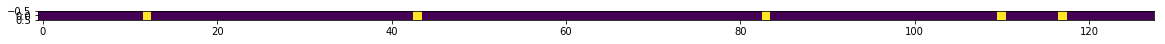

In [121]:
for i in range(1, se.max_val):
    sp.compute_SDR(se.encode(i))
    #sp.visualize_SDR()
    print(sp.test())
    
sp.compute_SDR(se.encode(3))
sp.visualize_SDR()

print(sp.test())
print("boost : \n", sp.boosts)
print("active : \n", sp.activeDutyInfo)
print("overlap : \n", sp.overlapDutyInfo)

In [ ]:
# 5. 제대로 된 data 주입해보기

import random

np.set_printoptions(threshold=np.nan)

sp = SpatialPooler(10,1024,.8,3)
        
step = 100
on_cnt = 5
rand_data = np.zeros([10])

y=np.empty([step])

for s in range(step):
    rand_data = np.zeros([10])
    
    for i in range(on_cnt):
        idx = random.randint(0,9)
        
        while(True):
            if(rand_data[idx] == 1):
                idx = random.randint(0,9)
            else:
                break
                
        rand_data[idx] = 1
        
    sp.compute_SDR(rand_data)
    y[s] = sp.visualize_SDR()
    #y.append(sp.visualize_SDR())
    
plt.plot(range(step), y)

print("boost : \n", sp.boosts)
print("active : \n", sp.activeDutyInfo)
print("overlap : \n", sp.overlapDutyInfo)

print("-"*50)
print("\n")
print("sparsity 평균 : {}, 표준편차 : {}\n".format(np.mean(y), np.std(y)))
print("activeDuty 평균 : {}, 표준편차 : {}\n".format(np.mean(sp.activeDutyInfo), np.std(sp.activeDutyInfo)))
print("overlap 평균 : {}, 표준편차 : {}\n".format(np.mean(sp.overlapDutyInfo), np.std(sp.overlapDutyInfo)))

C:\Anaconda\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


boost : 
 [1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2